# Is amplitude self-calibration viable and necessary?

This test run on W51-E B6, which looks quite bad even after phase self-calibration and a reasonably deep masked clean.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy import units as u

In [3]:
import pylab as pl
pl.rcParams['figure.figsize'] = (20,8)

In [4]:
import sys
sys.path.append('/lustre/naasc/users/aginsbur/repos/reduction/reduction/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube

In [5]:
import os
os.chdir("/lustre/naasc/projects/ALMA_IMF/2017.1.01355.L/")

In [6]:
from casatasks import gaincal

In [7]:
import selfcal_heuristics

In [127]:
caltable = 'W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_amp5_inf.cal/'
if not os.path.exists(caltable):
    gaincal(vis='W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_selfcal.ms/',
            caltable=caltable,
            solint='inf',
            calmode='ap',)

In [128]:
okfields,notokfields = selfcal_heuristics.goodenough_field_solutions(caltable,
                                                                     minsnr=5)
print(okfields, notokfields)

[16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 35] [11, 12, 13, 14, 15, 19, 24, 29, 33, 34, 36, 37]


In [129]:
import casatools
tb = casatools.table()

# this creates a "context manager" for the table tool that automatically handles tb.open/tb.close operations
class CasaTable(object):
    def __init__(self, file_name):
        self.tb = tb
        self.file_obj = tb.open(file_name)
    def __enter__(self):
        return self.tb
    def __exit__(self, type, value, traceback):
        self.tb.close()

In [130]:
msmd = casatools.msmetadata()

In [131]:
with CasaTable(caltable) as tb:
    print(tb.colnames())
    data = tb.getcol('CPARAM')
    amp = np.abs(data)
    angle = np.angle(data)
    time = tb.getcol('TIME')
    snr = tb.getcol('SNR') 
    antenna1 = tb.getcol('ANTENNA1')
    antenna2 = tb.getcol('ANTENNA2')
    obsid = tb.getcol('OBSERVATION_ID')
    spwid = tb.getcol('SPECTRAL_WINDOW_ID')
    fieldid = tb.getcol('FIELD_ID')
    data = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
data['ANGLE'] = angle
data['AMP'] = amp

['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


In [132]:
fids = np.unique(data['FIELD_ID'])
print(fids)

[11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37]


In [133]:
oids = np.unique(data['OBSERVATION_ID'])
print(oids)

[ 2  3 12]


In [134]:
spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
print(spwids)

[12 13 14 15 16 17 18 19 20 21 22 23 72 73 74 75 76 77]


In [135]:
# which observations contain which fields?
for oid in oids:
    oid_match = data['OBSERVATION_ID'] == oid
    has_fid = [fid for fid in fids if np.any((data['FIELD_ID'] == fid) & oid_match)]
    print(f"OID {oid} has fields {has_fid}")

OID 2 has fields [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
OID 3 has fields [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
OID 12 has fields [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


fid=11  mean=1.4136396310117938  median=1.1189990043640137  rms=0.7167808744997529
fid=12  mean=1.8044931264077633  median=1.5942904800487059  rms=1.0014155428497153
fid=13  mean=1.271061614376689  median=1.2670190334320068  rms=0.7784325416431324
fid=14  mean=2.007146150095394  median=1.527527719644815  rms=1.794874821520801
fid=15  mean=1.1966700793432896  median=1.0996562708477633  rms=0.3911094616913895
fid=16  mean=1.148273914608801  median=1.1260322043274036  rms=0.35433459767111675
fid=17  mean=1.0163508143730737  median=1.005324870093855  rms=0.23215722695322757
fid=18  mean=0.9863804275892468  median=0.957730253029557  rms=0.30659028002712935
fid=19  mean=2.1781169302068473  median=2.0750160032583413  rms=1.8966187956192728
fid=20  mean=1.111518919963206  median=1.0601488951144664  rms=0.3249580713788585
fid=21  mean=0.8838256398712437  median=0.8644171576233566  rms=0.22778621183715345
fid=22  mean=0.8169194403965898  median=0.8117087494662902  rms=0.17431350086590167
fid=23 

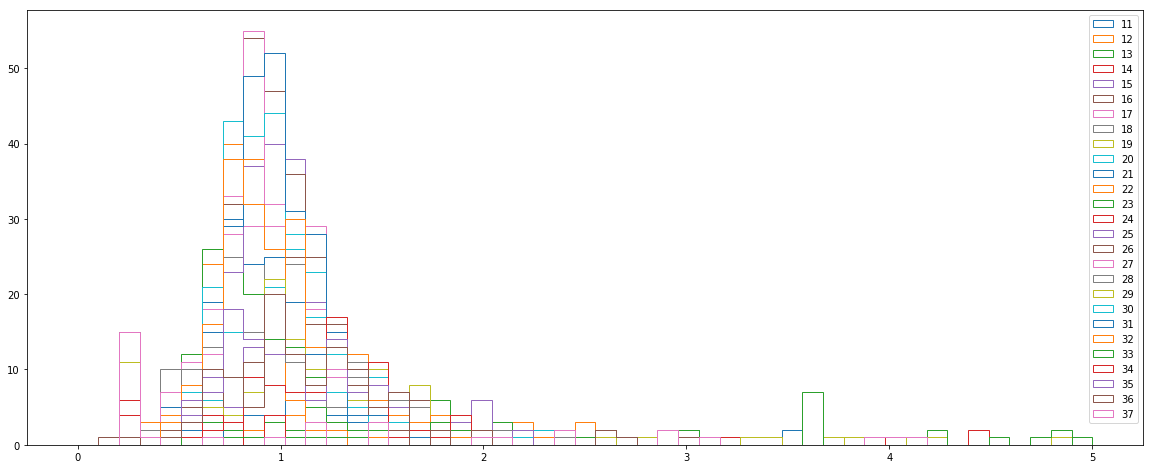

In [136]:
pl.clf()
fldstats = {}
for ii,fid in enumerate(np.unique(fieldid[obsid==2])):
    msk = (obsid==2) & (spwid == 16) & (fieldid==fid)
    if np.any(msk):
        dd = amp[0,0,msk]
        ok = (dd!=0) & (dd!=1)
        pl.hist(dd[ok], bins=np.linspace(0,5), histtype='step', label=f"{fid}")
        print(f"fid={fid}  mean={dd[ok].mean()}  median={np.median(dd[ok])}  rms={dd[ok].std()}")
        fldstats[fid] = [dd[ok].mean(), np.median(dd[ok]), dd[ok].std()]
pl.legend(loc='best')

In [137]:
fieldOKmask = np.isin(data['FIELD_ID'], okfields)

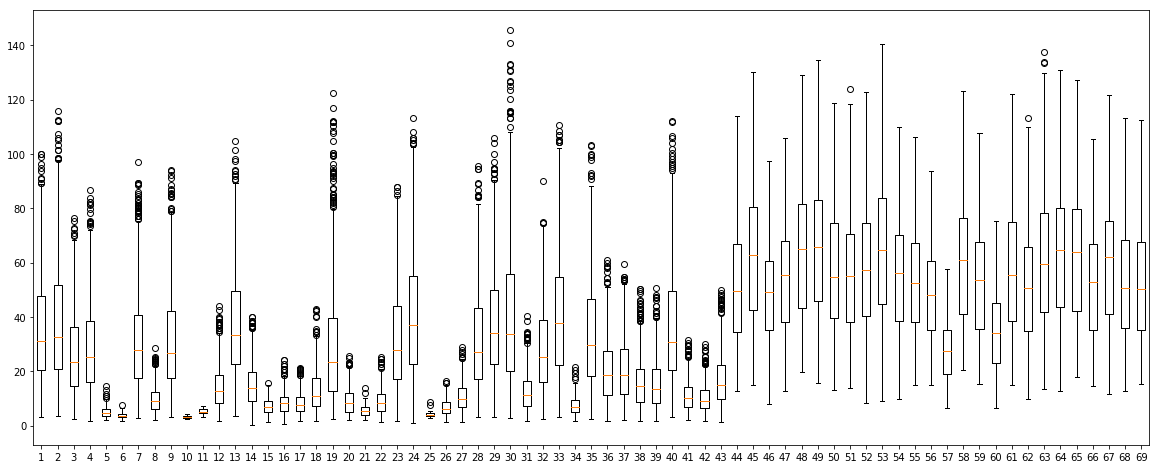

In [138]:
OK = data['SNR'] != 0

toplot = [data['SNR'][0,0, fieldOKmask & (OK[0,0,:]) & (data['ANTENNA1'] == ant)]
          for ant in np.unique(data['ANTENNA1'])]
toplot = [x for x in toplot if len(x) > 0]

_ = pl.boxplot(toplot)

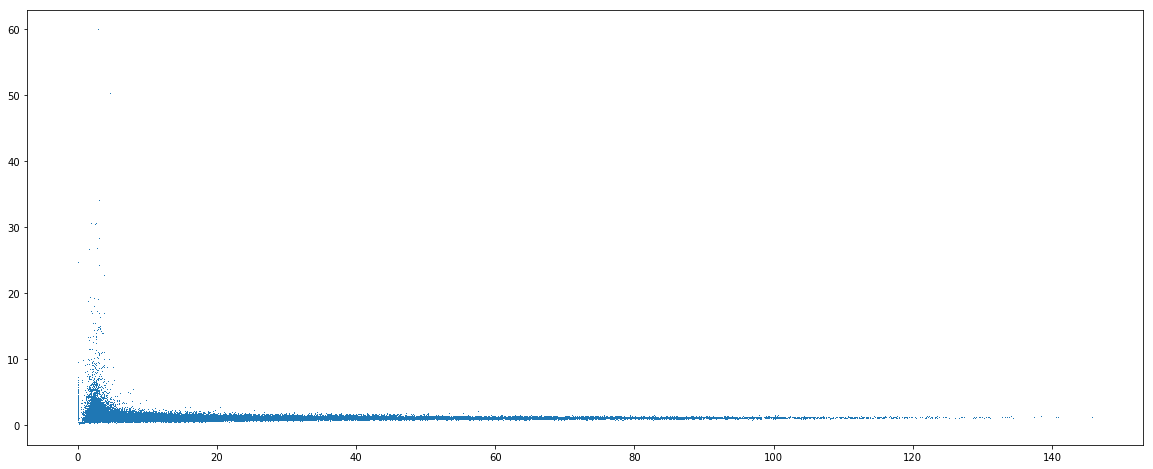

In [139]:
pl.plot(data['SNR'][0,0,:], data['AMP'][0,0,:], ',')

In [121]:
msmd.open('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_selfcal.ms/')
antobs = {}
obsid = data['OBSERVATION_ID']
for oid in np.unique(obsid):
    antids = np.unique(data['ANTENNA1'][(obsid==oid) & (OK[0,0,:])])
    antnames = {k:v for k,v in zip(antids, msmd.antennanames(antids))}

    center = (np.mean([msmd.antennaoffset(k)['latitude offset']['value'] for k in antnames]),
              np.mean([msmd.antennaoffset(k)['longitude offset']['value'] for k in antnames]),)
    print(oid, center)
    
    antdist = {k:((msmd.antennaoffset(k)['latitude offset']['value']-center[0])**2 + (msmd.antennaoffset(k)['longitude offset']['value']-center[1])**2)**0.5
               for k in antnames}
    antloc = {k:(msmd.antennaoffset(k)['latitude offset']['value'], msmd.antennaoffset(k)['longitude offset']['value'])
               for k in antnames}

    antobs[oid] = {'antnames': antnames,
                   'antdist': antdist,
                   'antloc': antloc}
msmd.close()
antdist = {(ant,oid): antobs[oid]['antdist'][ant] for oid in antobs for ant in antobs[oid]['antnames']}
antnames = {(ant,oid): antobs[oid]['antnames'][ant] for oid in antobs for ant in antobs[oid]['antnames']}

2 (-676.38481561887704, 50.474729370491879)
3 (-676.38481561887704, 50.474729370491879)
12 (-708.34688825572312, 22.236483871868082)


In [141]:
antstats = {}
for oid in np.unique(data['OBSERVATION_ID']):
    for antid in np.unique(data['ANTENNA1']):
        msk = (data['ANTENNA1'] == antid) & (OK[0,0,:]) & fieldOKmask & (data['OBSERVATION_ID'] == oid)
        if np.any(msk) and (antid, oid) in antnames:
            dat = data['SNR'][1,0, msk]
            ang = data['ANGLE'][1,0, msk]
            amp = data['AMP'][1,0, msk]
            print(f"antenna={antnames[(antid,oid)]} oid={oid} dist={antdist[(antid,oid)]:6.1f} "
                  f"mean={dat.mean():10.2f} median={np.median(dat):10.2f} "
                  f"std={dat.std():10.2f} amp mean={amp.mean():10.2f} "
                  f"amp std={amp.std():10.2f} angle_rms={ang.std()*180/np.pi:10.2f}")
            antstats[(antid,oid)] = {'mean':dat.mean(),
                               'median':np.median(dat),
                               'std': dat.std(),
                               'angle_rms': ang.std(),
                               'amp_mean': amp.mean(),
                               'amp_std': amp.std(),
                              }

antenna=DA41 oid=2 dist=  59.0 mean=     28.97 median=     22.84 std=     18.45 amp mean=      0.94 amp std=      0.18 angle_rms=      4.28
antenna=DA42 oid=2 dist=  19.2 mean=     30.72 median=     25.16 std=     19.33 amp mean=      0.90 amp std=      0.18 angle_rms=      4.59
antenna=DA43 oid=2 dist= 155.3 mean=     22.12 median=     17.18 std=     14.50 amp mean=      0.95 amp std=      0.24 angle_rms=      4.73
antenna=DA44 oid=2 dist=  63.2 mean=     22.23 median=     17.58 std=     14.62 amp mean=      0.92 amp std=      0.20 angle_rms=      4.12
antenna=DA45 oid=2 dist= 511.6 mean=      5.78 median=      5.31 std=      2.60 amp mean=      1.06 amp std=      0.21 angle_rms=      2.93
antenna=DA46 oid=2 dist= 819.0 mean=      3.16 median=      3.16 std=      0.00 amp mean=      1.12 amp std=      0.00 angle_rms=      0.00
antenna=DA47 oid=2 dist=  35.6 mean=     28.25 median=     23.08 std=     17.50 amp mean=      0.86 amp std=      0.21 angle_rms=      4.57
antenna=DA48 oid=2 d

In [142]:
[len([antstats[(ant,oid)]['mean'] for ant,_ in antstats  if (ant,oid) in antstats]) for oid in uoids]

[102, 103, 80]

In [143]:
[len([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats]) for oid in uoids]


[102, 103, 80]

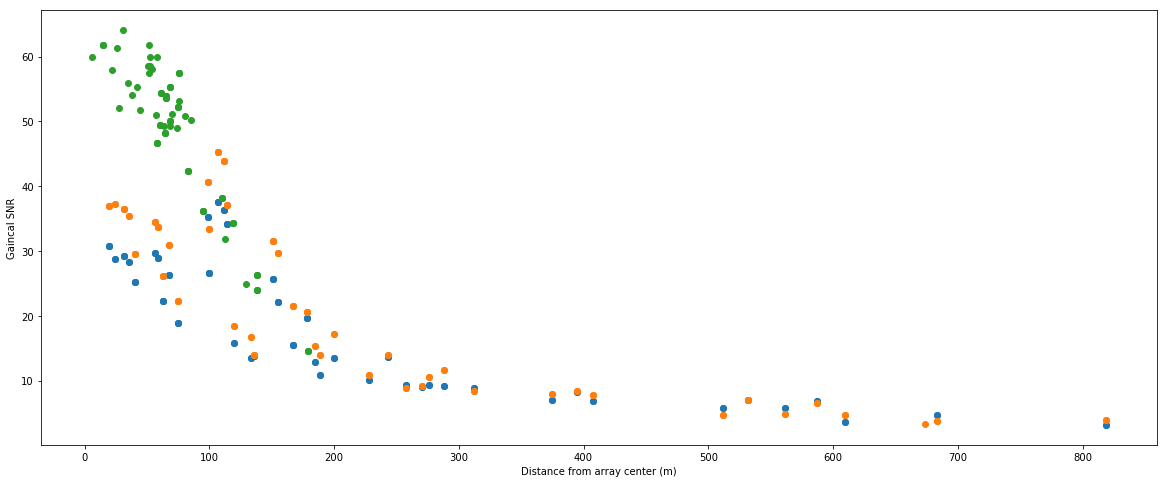

In [144]:
uoids = np.unique(data['OBSERVATION_ID'])
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Gaincal SNR")    

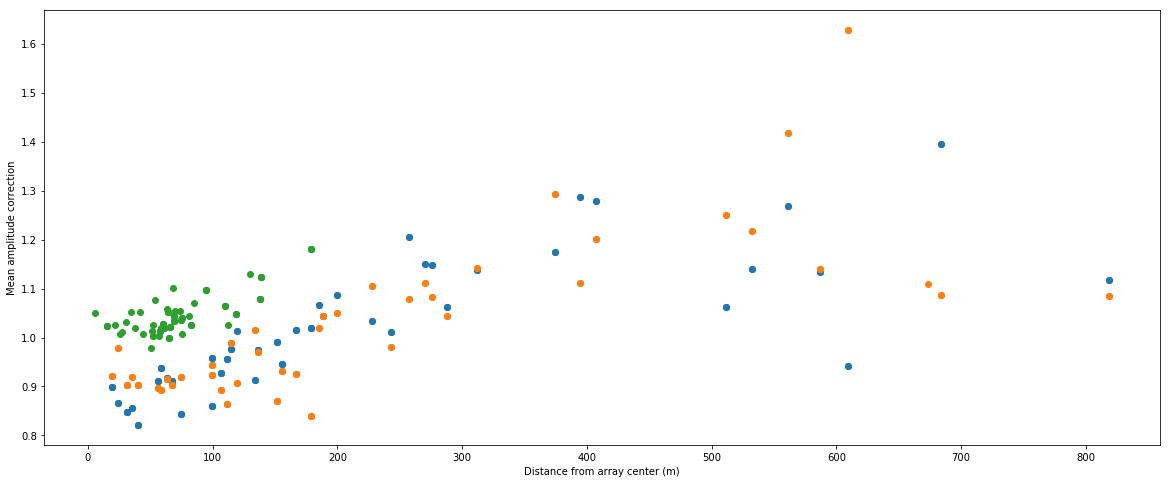

In [145]:
uoids = np.unique(data['OBSERVATION_ID'])
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['amp_mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Mean amplitude correction")

In [146]:
caltable = 'W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_amp6_inf.cal/'
with CasaTable(caltable) as tb:
    amp = np.abs(tb.getcol('CPARAM'))
    angle = np.angle(tb.getcol('CPARAM'))
    data6 = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
data6['ANGLE'] = angle
data6['AMP'] = amp

In [148]:
data=data6
fieldOKmask = np.isin(data['FIELD_ID'], okfields)
OK = data['SNR'] != 0
antstats = {}
for oid in np.unique(data['OBSERVATION_ID']):
    for antid in np.unique(data['ANTENNA1']):
        msk = (data['ANTENNA1'] == antid) & (OK[0,0,:]) & fieldOKmask & (data['OBSERVATION_ID'] == oid)
        if np.any(msk) and (antid, oid) in antnames:
            dat = data['SNR'][1,0, msk]
            ang = data['ANGLE'][1,0, msk]
            amp = data['AMP'][1,0, msk]
            print(f"antenna={antnames[(antid,oid)]} oid={oid} dist={antdist[(antid,oid)]:6.1f} "
                  f"mean={dat.mean():10.2f} median={np.median(dat):10.2f} "
                  f"std={dat.std():10.2f} amp mean={amp.mean():10.2f} "
                  f"amp std={amp.std():10.2f} angle_rms={ang.std()*180/np.pi:10.2f}")
            antstats[(antid,oid)] = {'mean':dat.mean(),
                               'median':np.median(dat),
                               'std': dat.std(),
                               'angle_rms': ang.std(),
                               'amp_mean': amp.mean(),
                               'amp_std': amp.std(),
                              }

antenna=DA41 oid=2 dist=  59.0 mean=     27.24 median=     21.35 std=     19.20 amp mean=      0.97 amp std=      0.10 angle_rms=      4.62
antenna=DA42 oid=2 dist=  19.2 mean=     28.96 median=     22.76 std=     20.23 amp mean=      0.98 amp std=      0.08 angle_rms=      5.20
antenna=DA43 oid=2 dist= 155.3 mean=     20.44 median=     15.48 std=     15.71 amp mean=      0.97 amp std=      0.12 angle_rms=      5.25
antenna=DA44 oid=2 dist=  63.2 mean=     21.00 median=     15.66 std=     15.32 amp mean=      0.99 amp std=      0.10 angle_rms=      4.79
antenna=DA45 oid=2 dist= 511.6 mean=      5.77 median=      5.28 std=      2.39 amp mean=      0.97 amp std=      0.07 angle_rms=      2.33
antenna=DA47 oid=2 dist=  35.6 mean=     26.77 median=     21.13 std=     18.54 amp mean=      0.98 amp std=      0.09 angle_rms=      5.14
antenna=DA48 oid=2 dist= 270.3 mean=      8.23 median=      7.05 std=      5.10 amp mean=      0.99 amp std=      0.11 angle_rms=      3.71
antenna=DA49 oid=2 d

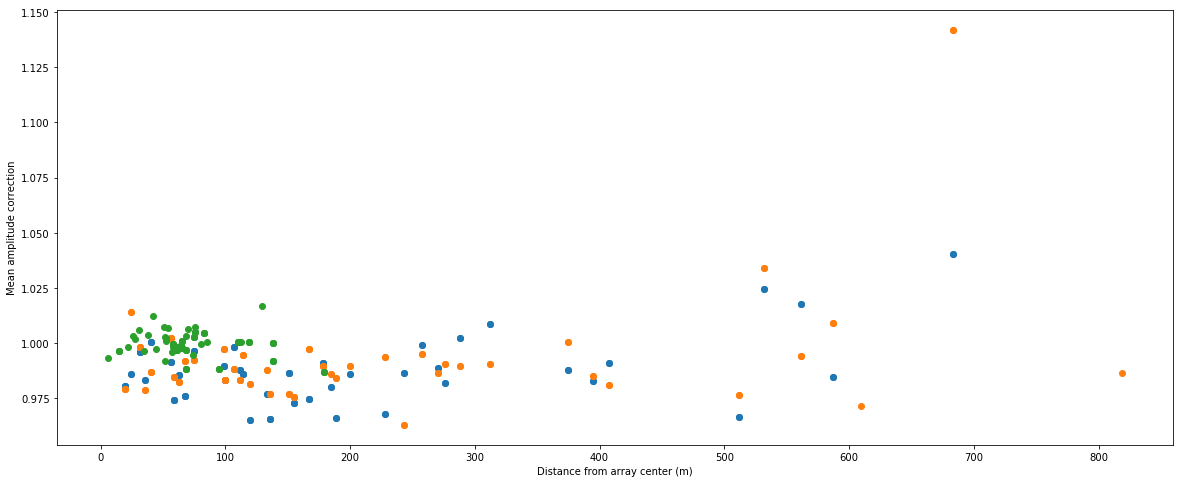

In [149]:
uoids = np.unique(data6['OBSERVATION_ID'])
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['amp_mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Mean amplitude correction")